# Deep Learning: CNN: Cancer Detection
**Thomas Bohn**   --   **2025-09-14**

{{xxxxx}}  

--  [Main Report](https://github.com/TOM-BOHN/MsDS-deep-learing-cnn-cancer-detection/blob/5b1494348403ed44ceaff077ec9d7809f6a518e4/deep_learning_cnn_cancer_detection.ipynb)  --  [Github Repo](https://github.com/TOM-BOHN/MsDS-deep-learing-cnn-cancer-detection/tree/main)  --

# 1.&nbsp;Introduction

**Problem Statement**

Using a Convolutional Neural Network (CNN), identify metastatic cancer in small image patches taken from larger digital pathology scans.

**Why is it Important?**

PCam is highly interesting for both its size, simplicity to get started on, and approachability. In the authors' words:

>[PCam] packs the clinically-relevant task of metastasis detection into a straight-forward binary image classification task, akin to CIFAR-10 and MNIST. Models can easily be trained on a single GPU in a couple hours, and achieve competitive scores in the Camelyon16 tasks of tumor detection and whole-slide image diagnosis. Furthermore, the balance between task-difficulty and tractability makes it a prime suspect for fundamental machine learning research on topics as active learning, model uncertainty, and explainability.

**Related Kaggle Competition**

[Histopathologic Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data)

**DataSet**

 This data set is a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.

**Data Facts**:
- **Data Size**: 7.76 GB
- **Training Data Records**: 220,025
- **Training Data Records**: 57,458
- **Classes**: 2 (Binary)
- **Fields**: Id, Label + Directory of .tif files

## Python Libraries

The following python libraries are used in this notebook.

In [5]:
# File system manangement
import time, datetime, psutil, os
import shutil
import zipfile
from google.colab import userdata
from google.colab import files

# Data manipulation
import numpy as np
import pandas as pd
import math

# Install text storage and manipulation
import re
import json
import pickle
import textwrap

#Install Image processing
from PIL import Image

##################################

# Plotting and visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import seaborn as sns
sns.set_theme()

# Train-test split and cross validation
from sklearn.model_selection import train_test_split, ParameterGrid

# Model Evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score

#################################

# Import Tensor Flow and Keras
import tensorflow as tf
import keras
from keras import layers, models
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, History
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

#################################

# Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Global Variables

The following are global variables referenced in this notebook.

In [4]:
# Recording the starting time, complemented with a stopping time check in the end to compute process runtime
start = time.time()

# Class representing the OS process and having memory_info() method to compute process memory usage
process = psutil.Process(os.getpid())

In [5]:
# Global Debug flag used to turn on and off more chatty blocks of code
gDEBUG = True
if gDEBUG: print('Debug is set to:', gDEBUG)
# Global Level of Detail of table stats and details
gLOD = 2
print('Level of Detail for functions is set to:', gLOD)

Debug is set to: True
Level of Detail for functions is set to: 2


# 2.&nbsp;Data Source

In this section, the code loads the dataset from Google Drive. A copy of the code from Kaggle was cached on google drive for development in a colab environment.

## Import the Data

In [6]:
# Define the source of the zipped data files
target_file = 'histopathologic-cancer-detection.zip'
source_path_root =  '/content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/data'
destination_path_root = '/content'

# Copy the files to the runtime
shutil.copy(source_path_root+'/'+target_file, destination_path_root+'/')

# Display the files in the destination directory
print(os.listdir(destination_path_root+'/'))

Mounted at /content/drive
['.config', 'histopathologic-cancer-detection.zip', 'drive', 'sample_data']


In [7]:
# Unzip the files (this is slow)
zip_file_path = destination_path_root+'/'+target_file

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all the contents into the specified folder
        zip_ref.extractall(destination_path_root)

In [8]:
# Define the file paths in the runtime environment
file_path_root =  '/content'

file_path_train   = file_path_root + '/train'
file_path_test    = file_path_root + '/test'
file_path_labels  = file_path_root + '/train_labels.csv'
file_path_sample  = file_path_root + '/sample_submission.csv'

# Load train labels from CSV file
train_labels = pd.read_csv(file_path_labels)

# Load test labels from CSV file
sample_output = pd.read_csv(file_path_sample)

In [9]:
if gDEBUG:
  # Preview the Data Sources
  print("Sample of Training Labels")
  display(train_labels.head(5))
  print()
  print("Sample of Results Output:")
  display(sample_output.head(5))

Sample of Training Labels


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0



Sample of Results Output:


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [10]:
# Display training labels info
print("Training Labels Info:")
print(train_labels.info())

Training Labels Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None


In [11]:
# Get training and testing files
train_file_names = os.listdir(file_path_train)
test_file_names = os.listdir(file_path_test)

# Display a summary of the files
print('Total Training Files: ', len(train_file_names))
print('Total Testing Files: ', len(test_file_names))

# Display the data split between test and train
# Split will be used to define the test valildation split later
pct_assigned_train = round(len(train_file_names) / (len(train_file_names) + len(test_file_names)), 3)
print('Percent Assigned to Training: ', pct_assigned_train)
print()

# Display a sample of file names
print('Preview of training image file names: ')
print(train_file_names[:5])
print('Preview of testing image file names: ')
print(test_file_names[:5])

Total Training Files:  220025
Total Testing Files:  57458
Percent Assigned to Training:  0.793

Preview of training image file names: 
['c823338229d6b73b00b7b4e55e7b699a3401ee3f.tif', '8d82f3bd017724fb7647df92fd501328d382a707.tif', 'dd3213361e77be50c160617223ca076111d3569f.tif', 'bef0b669b473bc2aff91467822f31167acaaf609.tif', '8dc08b595911a645f67bc3a5d6048cca2ed09985.tif', 'b9617df1085ba874cbbed39345d2c7ff09bcee5b.tif', '1ec5d65d222384d8e1fde325080a37dcb3bdf8f2.tif', '81b6880e7c30834bb6921fa925f7b5424c6a85da.tif', 'bef553a4d5fb9b60c3f938bfde475e9b194c7351.tif', 'bcc86858083649cf21f87e8a81af73585246be4f.tif']
Preview of testing image file names: 
['77c8a993a6554adb01847c6dad00debbdac42e6c.tif', '55244dff457bea22745ae67b3c4a87ac3c260ac6.tif', '50d0c5068db837b20292564c903ed1f902246d61.tif', 'e607d2e3693253a1ac55324de79ebe1f685451eb.tif', '2b29fe81d4545bc0a443c679a17eeeb8dcbe0483.tif', 'af438608ba4cb92d35cae44ed710f143563977cb.tif', '9941dc54d4568b5c1cd1c9054d6c3463371eb782.tif', 'a6ef9669

In [12]:
 # Preview the Training Label Assignments
print('Label Count of Training Labels')
display(train_labels['label'].value_counts())
print()
print('Imbalance of Labels:', round((train_labels['label'].value_counts()[1]
                                    - train_labels['label'].value_counts()[0]) / len(train_labels), 3))

Label Count of Training Labels


,count
label,
0,130908
1,89117



Imbalance of Labels: -0.19


# 3.&nbsp;Exploratory Data Analysis (EDA)

The EDA phase focuses on understanding the dataset, including data distribution and label counts. Additional a visual display of the images for the model are previewed to better understand the problem in scope.

## EDA Functions

In [17]:
# Helper function to display a preview of images in the directory
def preview_images(df, file_path_train, target_label, num_previews=2):
    previews = df[df['label'] == target_label].sample(num_previews)
    plt.figure(figsize=(15, 3))
    for idx, img_name in enumerate(previews['id']):
        img_path = file_path_train + '/' + img_name + '.tif'
        print(img_path)
        img = Image.open(img_path)
        plt.subplot(1, num_previews, idx+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'Preview of Images for Label {target_label}')
    plt.show()

## EDA Analysis: Image Preview

In [16]:
# Preview the images in both classes
preview_images(df=train_labels, file_path_train=file_path_train, target_label=0, num_previews=4)
preview_images(df=train_labels, file_path_train=file_path_train, target_label=1, num_previews=4)

NameError: name 'preview_images' is not defined

## EDA Analysis: Class Distribution

Size of the training set: 220025

Labels in training set: 2

Columns in test set: Index(['id', 'label'], dtype='object')



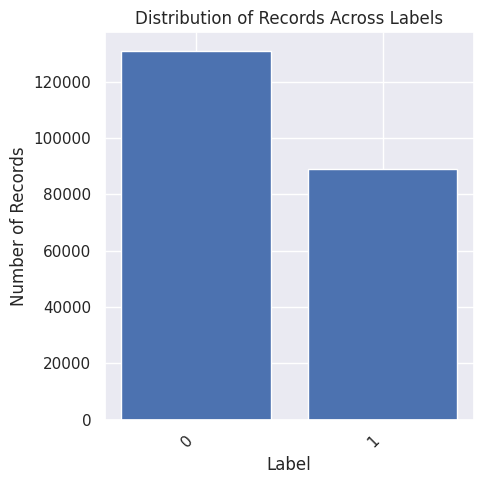

In [19]:
# Display summary stats on the training set
print("Size of the training set:", len(train_labels))
print()
print("Labels in training set:", train_labels['label'].nunique())
print()
print("Columns in test set:", train_labels.columns)
print()

# Create a histogram for the count of records in each label
label_counts = train_labels['label'].value_counts()
plt.figure(figsize=(5, 5))
plt.bar(label_counts.index.astype(str), label_counts.values)
plt.xlabel('Label')
plt.ylabel('Number of Records')
plt.title('Distribution of Records Across Labels')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## EDA Results

There is some imbalnce between the labels in the datset, but there is alot of data. The dataset can likely be sampled down to balance the data across both labels. Given CNN can be resource intensive, it is also possible a smaller dataset can support a high quality model, with lower costs (in resources).

# 4.&nbsp;Train-Validation-Test Split

Split the dataset into training, validation, and test sets. Use tratified splitting to ensure that the class distribution remains consistent across these sets. The distribution of records across the labels is visualized to ensure a balanced split.

## Trail-Vaildation-Test Split Functions

In [17]:
#Downsample the amount of records for testing (and balance classes)
def balance_and_sample(df, sample_size, label_col='label', random_state=27):

    df_0 = df[df[label_col] == 0].sample(sample_size, random_state = random_state)
    df_1 = df[df[label_col] == 1].sample(sample_size, random_state = random_state)

    df_balanced = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

    return df_balanced

# Reduce Record Volume

In [18]:
#Downsample the amount of records for testing (and balance classes)
train_labels_01k = balance_and_sample(df=train_labels, label_col='label', sample_size=80000, random_state=27)

NameError: name 'train_labels' is not defined

## Test Split Functions

In [21]:
# Split train and validate datasets
train_df, valid_df = train_test_split(train_labels_01k, test_size=0.2, stratify=train_labels_01k['label'], random_state=27)

In [22]:
# Clean data type an create file name column
train_df['label'] = train_df['label'].astype(str)
train_df['file_name'] = train_df['id'] + '.tif'

train_df.head(5)

,id,label,file_name
776,f4b2912f15511c7a9493661987ec33f97789bdb5,0,f4b2912f15511c7a9493661987ec33f97789bdb5.tif
577,a0df8aaedece8633049bdf5447d46939c5916327,0,a0df8aaedece8633049bdf5447d46939c5916327.tif
206,4676318b836d0b8abc65295e678050531df28bbe,0,4676318b836d0b8abc65295e678050531df28bbe.tif
864,a2c274926614081b22ed1dc65340f2688e48cd0c,0,a2c274926614081b22ed1dc65340f2688e48cd0c.tif
1419,68b97cab3f89d9f1ce7547792ad2ee7caac4c545,1,68b97cab3f89d9f1ce7547792ad2ee7caac4c545.tif


In [23]:
# Clean data type an create file name column
valid_df['label'] = valid_df['label'].astype(str)
valid_df['file_name'] = valid_df['id'] + '.tif'

valid_df.head(5)

,id,label,file_name
1115,a1bd178734975cb074ed8bdae7088d77aacd9bca,1,a1bd178734975cb074ed8bdae7088d77aacd9bca.tif
1870,2727414cb9e4561de7b5f4d56f4901c98f51c851,1,2727414cb9e4561de7b5f4d56f4901c98f51c851.tif
688,4fcd244b0478b53af5bc9a0a5225b0f846a5a977,0,4fcd244b0478b53af5bc9a0a5225b0f846a5a977.tif
192,320b6c62f8741d10f118be308f1b2f6ca1ec9703,0,320b6c62f8741d10f118be308f1b2f6ca1ec9703.tif
167,97ad518b77e5a19753cee93ec2acbc128b54b47d,0,97ad518b77e5a19753cee93ec2acbc128b54b47d.tif


## Test Split Analysis

In [26]:
 # Preview the Data Sources
print('Label Count of Training Labels')

display(train_df['label'].value_counts())
print()
print('Imbalance of Labels:', round((train_df['label'].value_counts()['1']
                                    - train_df['label'].value_counts()['0']) / len(train_df), 3))
print()
print('Label Count of Validation Labels')
display(valid_df['label'].value_counts())
print()
print('Imbalance of Labels:', round((valid_df['label'].value_counts()['1']
                                    - valid_df['label'].value_counts()['0']) / len(valid_df), 3))

Label Count of Training Labels


,count
label,
0,800
1,800



Imbalance of Labels: 0.0

Label Count of Validation Labels


,count
label,
1,200
0,200



Imbalance of Labels: 0.0


# 6.&nbsp;Image Preprocessing

Using [tf.keras.preprocessing.image.ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) complete image pre-processing to do light transformation to the input images.

In [29]:
#shared variables for image pre-processing
target_size = (96, 96)
batch_size=64

## Training Data Generator

In [45]:
# Create an image data generator
train_img_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True
)

# Create and configure a training data generator
train_generator = train_img_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=file_path_train,
    x_col='file_name',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary'
)

Found 1600 validated image filenames belonging to 2 classes.


## Validation Data Generator

In [46]:
# Create an image data generator
valid_img_gen = ImageDataGenerator(
    rescale=1./255
)

# Create and configure a training data generator
validation_generator = valid_img_gen.flow_from_dataframe(
    dataframe=valid_df,
    directory=file_path_train,
    x_col='file_name',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary'
)

Found 400 validated image filenames belonging to 2 classes.


## Testing Data Generator

In [47]:
test_df = pd.DataFrame({'id': os.listdir(file_path_test)})

test_img_gen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_img_gen.flow_from_dataframe(
    dataframe=test_df,
    directory=file_path_test,
    x_col='id',
    y_col=None,
    target_size=target_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode=None
)

Found 57458 validated image filenames.


# 7.&nbsp; Baseline Model

## Model Functions

In [9]:
def learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 10))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')

In [ ]:
class EpochTimeHistory(Callback):
    """A custom Keras callback to record the duration of each epoch."""
    def on_epoch_begin(self, epoch, logs=None):
        # Record the start time at the beginning of each epoch
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        # Calculate the epoch's duration
        epoch_duration = time.time() - self.epoch_start_time

        # Add the duration to the logs dictionary.
        # Keras will automatically include this in the final history object.
        if logs is not None:
            logs['epoch_duration'] = epoch_duration

In [60]:
save_dir = '/content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/saved_models'
os.makedirs(save_dir, exist_ok=True) # This creates the folder if it doesn't exist

## Build the Model Architecture

In [62]:
config_model_0 = [
    # Define the input shape
    Input(shape=(96, 96, 3)),
    #Layer 1
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    #Layer 2
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # ANN
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
]

In [63]:
model_0 = Sequential(config_model_0)

In [64]:
learning_rate_model_0 = 0.001
optimizer_model_0 = keras.optimizers.Adam(learning_rate = learning_rate_model_0)

In [65]:
model_0.compile(
    optimizer = optimizer_model_0,
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [66]:
model_0.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,984,577 (15.20 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

### Train/Fit the Model

In [67]:
# Define the size of the subset you want to use for training
subset_size = 1000
batch_size = 64
steps_per_epoch = math.ceil(subset_size / batch_size)

time_history_callback_0 = EpochTimeHistory()

history_0 = model_0.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs = 10,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch,
    callbacks=[time_history_callback_0]
)
history_0

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5027 - loss: 1.1497 - val_accuracy: 0.6375 - val_loss: 0.6445
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7084 - loss: 0.6048 - val_accuracy: 0.7975 - val_loss: 0.4908
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7526 - loss: 0.5124 - val_accuracy: 0.7800 - val_loss: 0.4840
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7419 - loss: 0.5247 - val_accuracy: 0.7775 - val_loss: 0.4892
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7521 - loss: 0.5215 - val_accuracy: 0.7200 - val_loss: 0.5612
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7407 - loss: 0.5296 - val_accuracy: 0.7675 - val_loss: 0.4868
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7869 - loss: 0.4845 - val_accuracy: 0.8050 - val_loss: 0.4605
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7927 - loss: 0.4790 - val_accuracy: 0.8100 - val_loss:

In [69]:
model_0_path = os.path.join(save_dir, 'cnn_model_0.keras')
history_0_path = os.path.join(save_dir, 'cnn_history_0.pkl')
model_0.save(model_0_path)
with open(history_0_path, 'wb') as f:
    pickle.dump(history_0.history, f)

print(f"History saved to {save_dir}")

History saved to /content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/saved_models


### Evaluate the Model

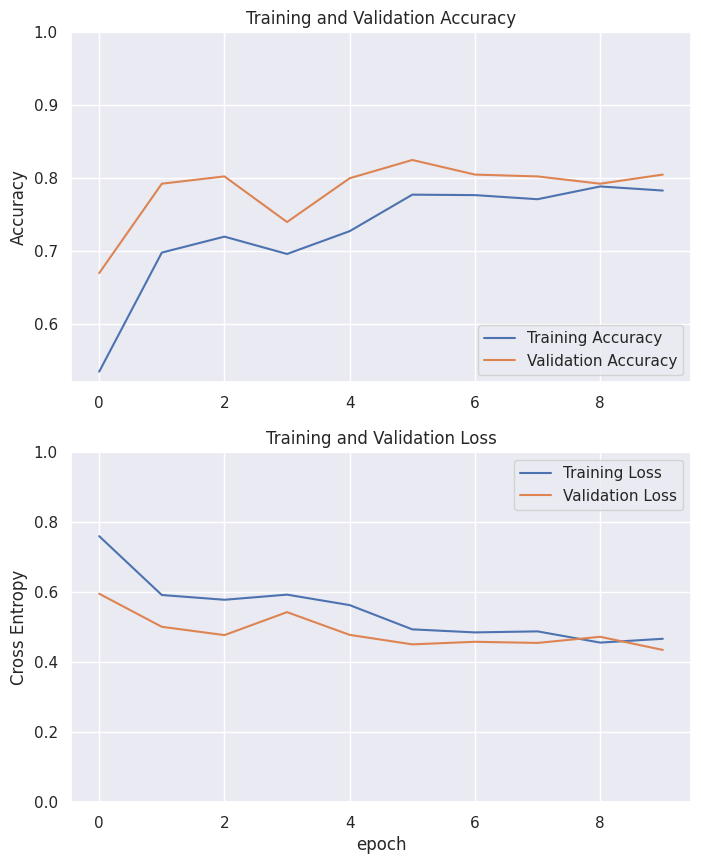

In [53]:
learning_curve(history_0)

# 8.&nbsp; Hyperparameter Tuning

## Improvement 1: Adding More Layers

In [59]:
config_model_1 = [
    # Define the input shape
    Input(shape=(96, 96, 3)),
    #Layer 1
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    #Layer 2
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Layer 3
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Layer 4
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # ANN
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
]

model_1 = Sequential(config_model_1)

learning_rate_model_1 = 0.001
optimizer_model_1 = keras.optimizers.Adam(learning_rate = learning_rate_model_1)

model_1.compile(
    optimizer = optimizer_model_1,
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

model_1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,486,593 (9.49 MB)

 Trainable params: 2,486,593 (9.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define the size of the subset you want to use for training
subset_size = 1000
batch_size = 64
steps_per_epoch = math.ceil(subset_size / batch_size)

time_history_callback_1 = EpochTimeHistory()

history_1 = model_1.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs = 10,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch,
    callbacks=[time_history_callback_1]
)
history_1

In [ ]:
learning_curve(history_1)

## Improvement 2: Batch Normalization and Dropout

In [ ]:
config_model_2 = [
    # Define the input shape
    Input(shape=(96, 96, 3)),
    #Layer 1
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    #Layer 2
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    # Layer 3
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    # Layer 4
    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    # ANN
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
]

model_2 = Sequential(config_model_2)

learning_rate_model_2 = 0.001
optimizer_model_2 = keras.optimizers.Adam(learning_rate = learning_rate_model_2)

model_2.compile(
    optimizer = optimizer_model_2,
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

model_2.summary()

In [ ]:
# Define the size of the subset you want to use for training
subset_size = 1000
batch_size = 64
steps_per_epoch = math.ceil(subset_size / batch_size)

# Callbacks for early stopping and reducing learning rate
time_history_callback_2 = EpochTimeHistory()
early_stopping_2 = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_2 = model_2.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs = 10,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch,
    callbacks = [early_stopping_2, time_history_callback_2]
)
history_2

In [ ]:
learning_curve(history_2)

## Improvement 3: Slower Learning, More Epics, Early Stopping

In [ ]:
config_model_3 = [
    # Define the input shape
    Input(shape=(96, 96, 3)),
    #Layer 1
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    #Layer 2
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    # Layer 3
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    # Layer 4
    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    # ANN
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
]

model_3 = Sequential(config_model_2)

learning_rate_model_3 = 0.001
optimizer_model_3 = keras.optimizers.Adam(learning_rate = learning_rate_model_3)

model_3.compile(
    optimizer = optimizer_model_3,
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

model_3.summary()

In [ ]:
# Define the size of the subset you want to use for training
subset_size = 1000
batch_size = 64
steps_per_epoch = math.ceil(subset_size / batch_size)

# Callbacks for early stopping and reducing learning rate
time_history_callback_3 = EpochTimeHistory()
early_stopping_3 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_3 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.000001)

history_3 = model_3.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs = 10,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch,
    callbacks = [early_stopping_3, reduce_lr_3, time_history_callback_3]
)
history_3

In [ ]:
learning_curve(history_3)

# 9.&nbsp;Final Prediction and Evaluation

## Evaluation Functions

In [ ]:
{{xxxxx}}

## Train the Final Model

In [6]:
save_dir = '/content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/saved_models'
model_0_path = os.path.join(save_dir, 'cnn_model_0.keras')
history_0_path = os.path.join(save_dir, 'cnn_history_0.pkl')

loaded_model_0 = models.load_model(model_0_path)

with open(history_0_path, 'rb') as f:
    loaded_history_dict_0 = pickle.load(f)

loaded_history_0 = History()
loaded_history_0.history = loaded_history_dict_0
loaded_history_0.epoch = list(range(len(loaded_history_dict_0['loss'])))

## Evaluate the Model

In [10]:
loaded_model_0.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,953,733 (45.60 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,969,156 (30.40 MB)

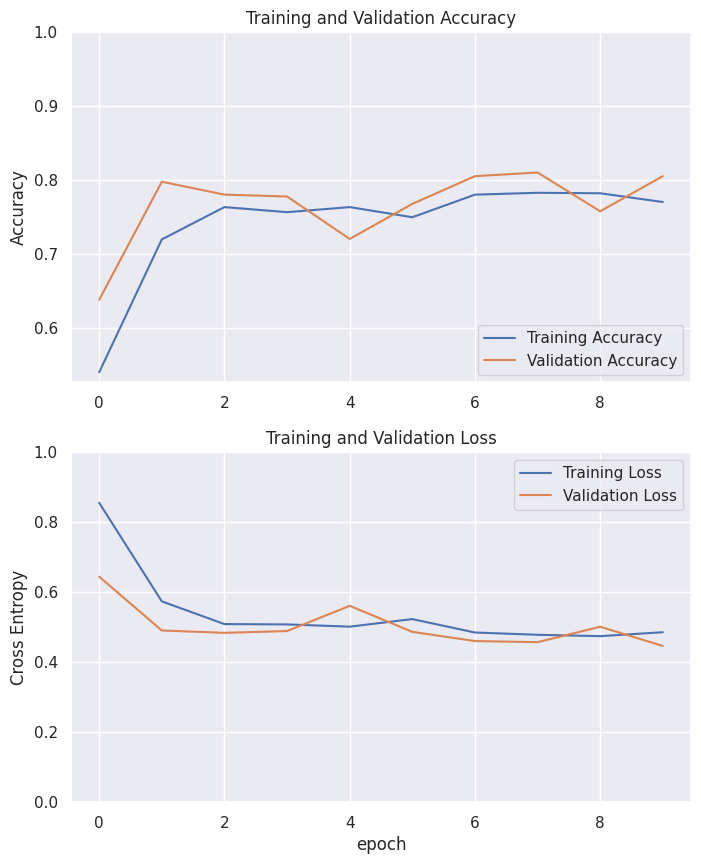

In [11]:
learning_curve(loaded_history_0)

In [12]:
history_0

NameError: name 'history_0' is not defined

In [15]:
history_0_df = pd.DataFrame(loaded_history_0.history)
history_0_df.index += 1
print("\n--- Full Training History with Epoch Times ---")
print(history_0_df)


--- Full Training History with Epoch Times ---
    accuracy      loss  val_accuracy  val_loss
1   0.539375  0.855527        0.6375  0.644484
2   0.719375  0.573922        0.7975  0.490798
3   0.763125  0.509067        0.7800  0.484011
4   0.756250  0.508100        0.7775  0.489167
5   0.763125  0.501685        0.7200  0.561175
6   0.749375  0.523274        0.7675  0.486802
7   0.780000  0.484952        0.8050  0.460543
8   0.782500  0.478486        0.8100  0.457401
9   0.781875  0.474580        0.7575  0.501432
10  0.770000  0.485793        0.8050  0.446620


## Explore Errors

In [ ]:
{{xxxxx}}

# 10.&nbsp;Scale the Auto-Classifier

## Auto-Classifier Functions

In [ ]:
{{xxxxx}}

## Rerun Process for L1

In [ ]:
{{xxxxx}}

## Rerun Process for L2

In [ ]:
{{xxxxx}}

# 11.&nbsp; Conclusions

{{xxxxx}}

## Results Summary

### Model Result Summary


**Baseline Results**

{{xxxxx}}

**Hyperparameter Tuning Results**

{{xxxxx}}

**Best Model Results**

{{xxxxx}}

**Best Model Performance**

{{xxxxx}}

## Model Comparison

### Model Comparisons and Findings

{{xxxxx}}

#### Baseline Results

{{xxxxx}}

#### Hyperparameter Tuning

{{xxxxx}}

#### Best Model Results

{{xxxxx}}

#### Performance Breakdown (Best Model)

{{xxxxx}}

#### Conclusion

{{xxxxx}}

## Concluding Observations

## Patterns and Conclusions Across the Models

{{xxxxx}}

# 12.&nbsp; References

**Kaggle Competition**

- [1] Will Cukierski. Kaggle. 2018. Histopathologic Cancer Detection. https://www.kaggle.com/c/histopathologic-cancer-detection/overview

**Kaggle File Import to Colab**
- [2] Abdul Qadir. 2020. Data Preparation Guide for detecting Histopathologic Cancer Detection https://towardsdatascience.com/data-preparation-guide-for-detecting-histopathologic-cancer-detection-7b96d6a12004/
- [3] Abdul Qadir. 2020. Histopathlogic-Cancer-Data-Preprocessing. https://github.com/DarthQadir/Histopathlogic-Cancer-Data-Preprocessing/tree/master

**References Resources**
- [4] Faramarz Kowsari. CNN_Histopathologic_Cancer_Detection_Colorado. 2023. https://www.kaggle.com/code/faramarzkowsari/cnn-histopathologic-cancer-detection-colorado
- [5] Kodai Fukuda. Histopathologic Cancer Detection with CNN. 2024. https://www.kaggle.com/code/kodaifukuda0311/histopathologic-cancer-detection-with-cnn